In [127]:
%reload_ext autoreload
%autoreload 2

# Run a conceptual model

**Before we start**

- This tutorial is rendered from a Jupyter notebook that is hosted on GitHub. If you'd like to run the code yourself, you can access the notebook and configuration files directly from the repository: [01-RunConceptModel Tutorial.](https://github.com/torchHydroNodes/torchHydroNodes/tree/master/tutorials/01-RunConceptModel).

- To run this notebook locally, ensure you have completed the setup steps outlined in [Getting started](https://torchhydronodes.readthedocs.io/en/latest/usage/getting_started.html). These steps include setting up the environment, installing the required packages, and preparing the data files necessary for the tutorial.

# Import packages

In [128]:
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dynamically set the project directory based on the notebook's location
notebook_dir = Path().resolve()
project_dir = str(notebook_dir.parent.parent)  # Adjust based on your project structure
sys.path.append(project_dir)

from src.thn_run import (
    _load_cfg_and_ds,
    get_basin_interpolators
)

from src.modelzoo_concept import get_concept_model

from src.utils.log_results import (
    save_and_plot_simulation,
    compute_and_save_metrics,
)

from tutorials.utils import (
    display_run_plots
)

# Constants

In [129]:
config_file = 'config_run_concept.yml'

# Load config file and prepare dataset

In [130]:
cfg, dataset = _load_cfg_and_ds(Path(config_file), model='conceptual')

-- Loading the config file and the dataset
-- Using device: cpu --
Setting seed for reproducibility: 111
-- Loading basin dynamics into xarray data set.
100%|██████████| 4/4 [00:00<00:00, 12.31it/s]


In [131]:
cfg._cfg['experiment_name']

'run_concept_model'

A folder has been created in the ```runs``` directory with the name specified as ```experiment_name``` in the configuration file, appended with a ```YYMMDD_HHMMSS``` timestamp. This folder will contain the configuration, results, plots, and metrics associated with the run.

## Explore cfg file and created dataset

In [132]:
# Inputs taken from the config file and generated as needed
cfg._cfg.keys()

dict_keys(['dataset', 'concept_data_dir', 'forcings', 'basin_file', 'concept_model', 'ode_solver_lib', 'odesmethod', 'time_step', 'train_start_date', 'train_end_date', 'valid_start_date', 'valid_end_date', 'metrics', 'experiment_name', 'device', 'seed', 'precision', 'verbose', 'config_dir', 'basin_file_path', 'concept_inputs', 'concept_target', 'periods', 'run_dir', 'plots_dir', 'results_dir', 'number_of_basins'])

In [133]:
# Dataset attributes
dataset.__dict__.keys()

dict_keys(['cfg', 'is_train', '_compute_scaler', 'scaler', 'basins', '_disable_pbar', '_per_basin_target_stds', '_dates', 'start_and_end_dates', 'num_samples', 'period_starts', 'alias_map', 'alias_map_clean', 'ds_train', 'ds_valid', 'ds_static'])

In [134]:
display(
    'basins', dataset.basins,
    'start_and_end_dates', dataset.start_and_end_dates,
    'ds_train', dataset.ds_train,
    'ds_valid', dataset.ds_valid,
)

'basins'

['01013500', '01022500', '01030500', '06431500']

'start_and_end_dates'

{'train': {'start_date': Timestamp('1980-10-01 00:00:00'),
  'end_date': Timestamp('2000-09-30 00:00:00')},
 'valid': {'start_date': Timestamp('2000-10-01 00:00:00'),
  'end_date': Timestamp('2010-09-30 00:00:00')}}

'ds_train'

<xarray.Dataset> Size: 994kB
Dimensions:     (basin: 4, date: 7305)
Coordinates:
  * date        (date) datetime64[ns] 58kB 1980-10-01 1980-10-02 ... 2000-09-30
  * basin       (basin) <U8 128B '01013500' '01022500' '01030500' '06431500'
Data variables:
    dayl        (basin, date) float32 117kB 11.33 11.28 11.23 ... 11.52 11.42
    obs_runoff  (basin, date) float32 117kB 0.551 0.5607 0.5586 ... 0.441 0.4353
    prcp        (basin, date) float32 117kB 3.1 4.24 8.02 15.27 ... 0.0 0.0 0.0
    srad        (basin, date) float32 117kB 192.6 206.3 165.4 ... 350.7 303.8
    tmax        (basin, date) float32 117kB 10.05 15.82 15.86 ... 22.11 19.83
    tmean       (basin, date) float32 117kB 6.08 10.53 11.84 ... 13.41 12.77
    tmin        (basin, date) float32 117kB 2.11 5.24 7.81 ... 1.95 4.71 5.72
    vp          (basin, date) float32 117kB 711.3 898.6 ... 755.6 868.9

'ds_valid'

<xarray.Dataset> Size: 497kB
Dimensions:     (basin: 4, date: 3652)
Coordinates:
  * date        (date) datetime64[ns] 29kB 2000-10-01 2000-10-02 ... 2010-09-30
  * basin       (basin) <U8 128B '01013500' '01022500' '01030500' '06431500'
Data variables:
    dayl        (basin, date) float32 58kB 11.33 11.28 11.23 ... 11.52 11.52
    obs_runoff  (basin, date) float32 58kB 0.1158 0.1126 ... 0.4525 0.4525
    prcp        (basin, date) float32 58kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    srad        (basin, date) float32 58kB 327.8 331.3 314.3 ... 352.8 363.1
    tmax        (basin, date) float32 58kB 20.31 20.4 20.0 ... 26.98 20.26 19.66
    tmean       (basin, date) float32 58kB 12.23 11.92 12.17 ... 12.22 11.05
    tmin        (basin, date) float32 58kB 4.16 3.44 4.34 ... 8.61 4.18 2.44
    vp          (basin, date) float32 58kB 822.2 783.9 827.6 ... 810.6 710.9

Feel free to generate plots form the training and validation sets to get familiar with the data

# Create interpolators

As the time-series data was loaded on a one-day resolution, we need to run interpolation during the solution of the system of ODEs for adaptative-step methods and fixe-step methods with higher resolution.

In [135]:
# Get the basin interpolators
interpolators = get_basin_interpolators(dataset, cfg, project_dir)

# Run the model and save the results

In [136]:
for basin in tqdm(dataset.basins, disable=cfg .disable_pbar, file=sys.stdout):

    for period in dataset.start_and_end_dates.keys():
        
        if period in ['train', 'valid']:
            if period == 'train':
                time_idx0 = 0
                data = dataset.ds_train
            else:
                time_idx0 = len(dataset.ds_train['date'].values)
                data = dataset.ds_valid

            model_concept = get_concept_model(
                cfg, data, interpolators, time_idx0, dataset.scaler, odesmethod=cfg.odesmethod
            )
            basin_data = data.sel(basin=basin)

        # Update Initial states for the model if period is not 'train'
        if period != 'train':
            model_concept.shift_initial_states(dataset.start_and_end_dates, basin, period=period)
    
        # Run the model
        model_results = model_concept.run(basin=basin)

        if model_results is None:
            continue

        # Save the results
        model_concept.save_results(basin_data, model_results, 
                                   basin, period=period)
        
        # Plot the results 
        save_and_plot_simulation(ds=basin_data,
                            q_bucket=model_results[-1],
                            basin=basin,
                            period=period,
                            model_name=cfg.concept_model,
                            plots_dir=cfg.plots_dir,
                            plot_prcp=False
                        )

100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


# Test the model (compute metrics)

In [137]:
run_dir = cfg.run_dir

# After the model has been run for all basins and periods 
# Evaluate the model - Compute the metrics
compute_and_save_metrics(metrics=cfg.metrics, run_dir=run_dir)

# Load plots

Latest folder: runs/run_concept_model_241125_183422


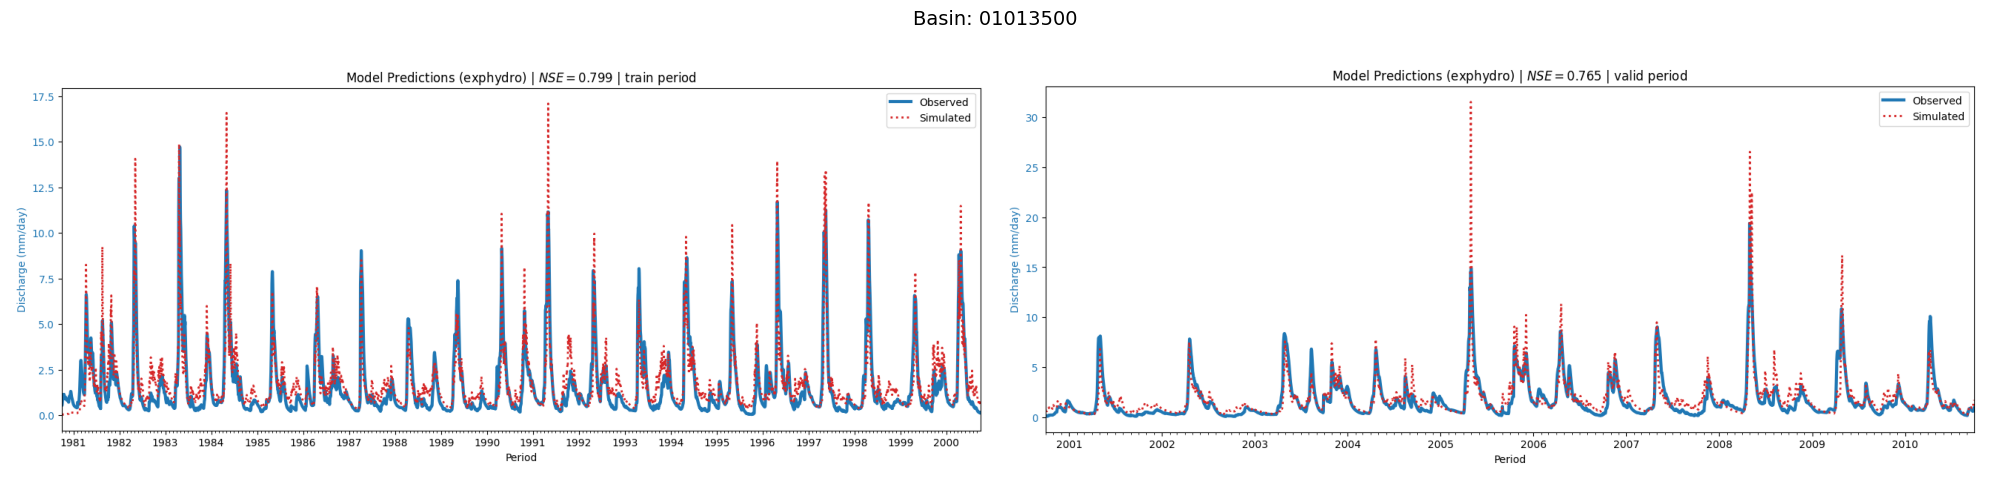

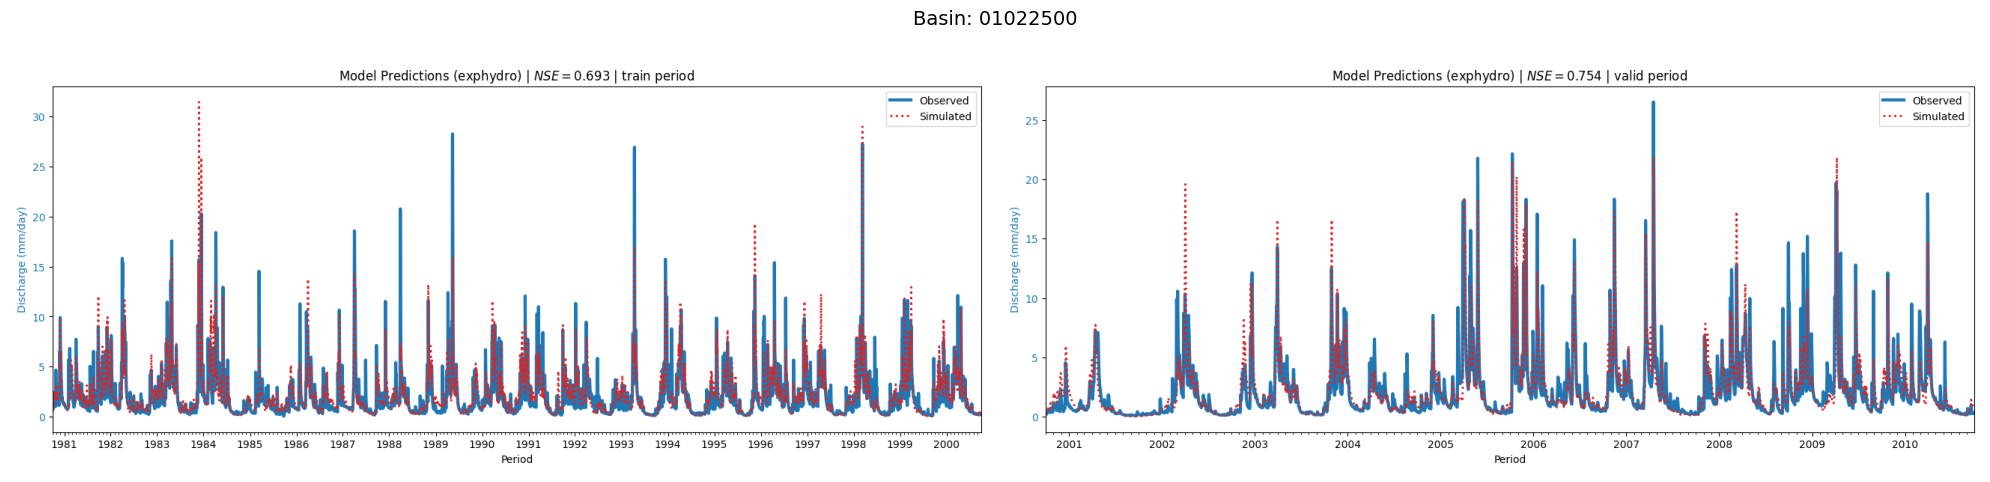

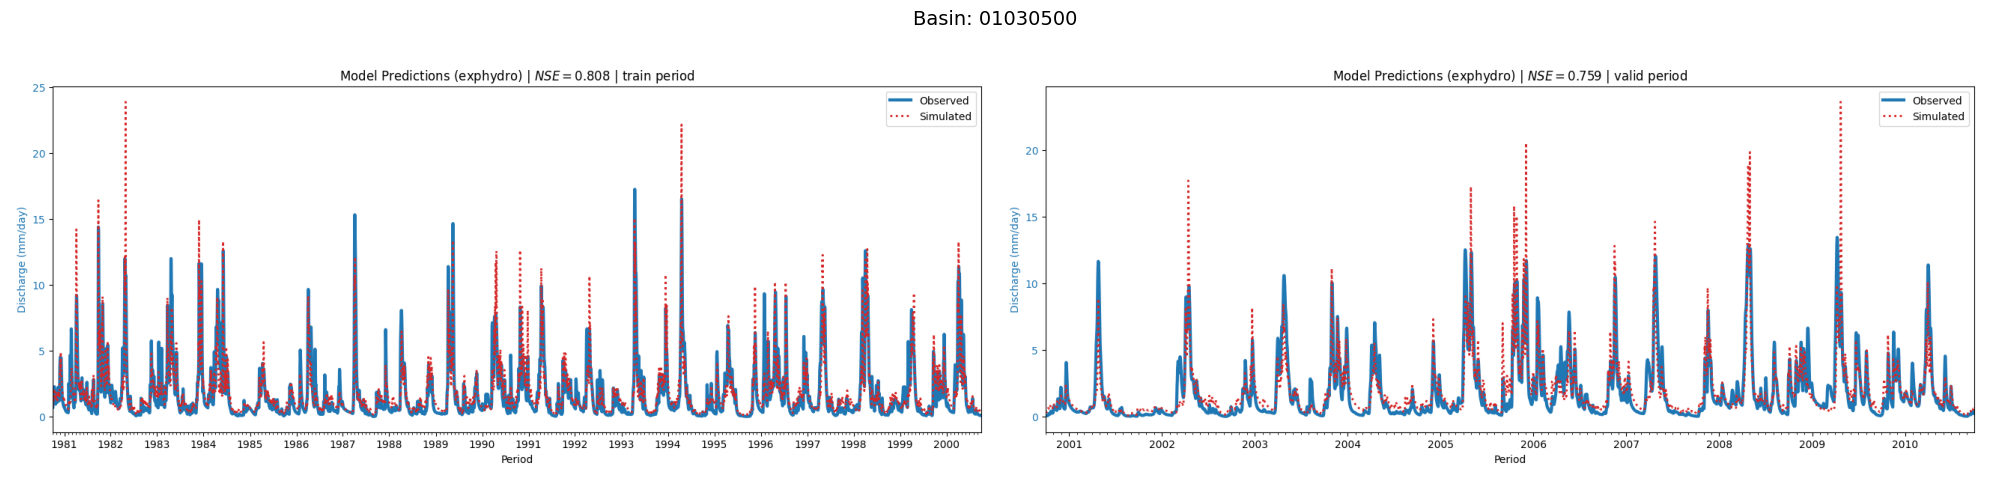

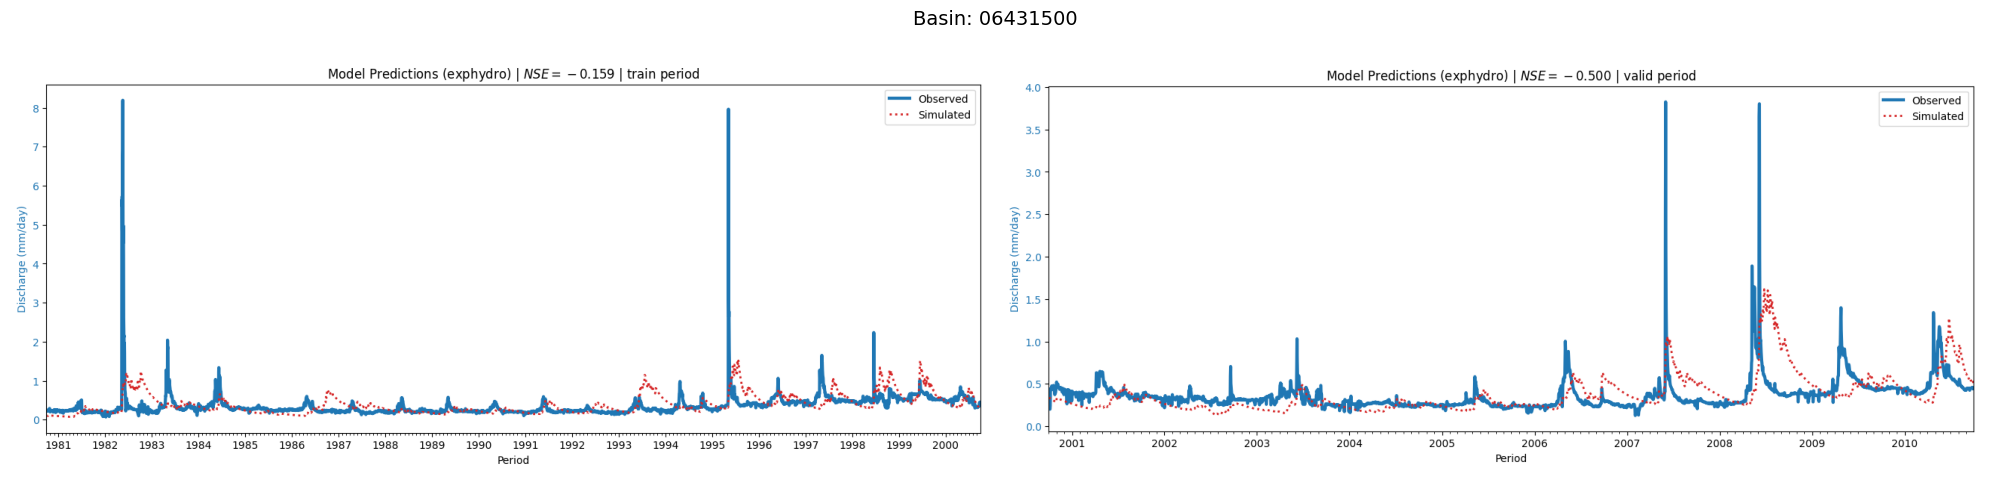

In [138]:
# Example usage
display_run_plots(
    basins=dataset.basins, 
    periods=list(dataset.start_and_end_dates.keys())
)